## GENEROWANIE NAJKRÓTSZYCH TRAS

W celu obliczenia najkrótszej trasy możliwej do pokonania przez pojazd, poruszający się po zadanym zakręcie, skorzystamy z funkcji generującej 1000 losowych zakrętów. Jest ona złożona z pętli, która przechodzi po kolejnych elementach, losowowo wygenerowanych tablic, zmiennych mieszczących się w zadeklarowanym przedziale. Tutaj ze względu na ogarniczenia, aby żadna wygenerowana droga nie wychodziła poza trasę, eliminujemy trasy które nie mieszczą się w ograniczeniach (ograniczenie_g oraz ograniczenie_d).

In [1]:
using Distributions
using Plots
using QuadGK
using ForwardDiff
using DataFrames

ograniczenie_d = 10 # promien krótszego łuku
ograniczenie_g = 20 # promien dluzszego luku
punktp_sx = 15 # z tego punktu start (x = 15)
punktp_sy = 0 # z tego punktu start (y =0)

# Tworzenie trasy
f(x) = ograniczenie_g*sin(x)
g(x) = ograniczenie_g*cos(x)
h(x) = ograniczenie_d*sin(x)
j(x) = ograniczenie_d*cos(x)
tab1 = [g, j]
tab2 = [f, h]

tab3 = Array{Function}(undef, 0)
tab4 = Array{Function}(undef, 0)
tab_dlugosci_luku = []
tab_dlugosci_luku_2 = []
x3 = []
y = []
r = []
al = []
dl = []
k = rand(Uniform(-300, 0), 1000) # 1000 przypadkowych wartości z przedziału
c = rand(Uniform(-300, 300), 1000)

for t1 in k
    for t2 in c
        x2 = t1
        y3 = x2 + t2
        r1 = sqrt((x2-punktp_sx)^2 + (y3)^2) # promien danego okregu
        odl = sqrt((x2)^2 + (y3)^2) # odl miedzy punktem (0,0), a srodkiem danego okregu
        y0 = y3 + sqrt((r1)^2 + (x2)^2) # punkt przeciecia z osia OY (0, y0)
        dluod = sqrt(15^2 + y0^2) # odl miedzy punktem (15,0) a (0,y0)
        if abs(r1-ograniczenie_d) > odl && y0 < ograniczenie_g # ograniczenia
            al1 = acos(1-((dluod^2)/(2*r1^2))) # kąt tworzony przez punkty: (0,y0), sr danego okregu i (15,0) 
            dl1 = al1*r1  # dlugosc luku okregu miedzy (0,y0) i (15,0)
            push!(y, y3)
            push!(x3, x2)
            push!(r, r1)
            push!(al, al1)
            push!(dl, dl1)
        end
    end
end

for s in 1:length(r)
    p(x) = r[s]*sin(x) + y[s]
    q(x) = r[s]*cos(x) + x3[s]
    push!(tab3, q)
    push!(tab4, p)
end

## WYGENEROWANIE TRAS NA WYKRESIE

In [2]:
plot(tab3, tab4, -pi, pi, aspectratio=1, linewidth=1, xlim=(0, ograniczenie_g),
     ylim=(0, ograniczenie_g), legend=false)
plot!(tab1, tab2, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)

## OBLICZANIE DROGI JAKĄ POKONA POJAZD

### WYNIK OCZEKIWANY

Analizując podstawowy wzór fizyczny jakim jest
\begin{equation*} 
\displaystyle s=\int \operatorname{d}\!s=\int v(t)\operatorname{d}\!t=\int r(\theta)\operatorname{d}\!\theta,
\end{equation*} 
jesteśmy w stanie za pomocą badania zmiany kąta w konkretnym punkcie obliczyć optymalną drogę jaką powinien pokonać bolid aby ta była jak najbardziej optymalna. Tutaj dodatkowo posiłkując się spiralą Eulera (pojazd poruszający się po klotoidzie ze stałą prędkością liniową ma jednostajne przyspieszenie kątowe i jednostajnie rosnącą siłę odśrodkową) jesteśmy w stanie wyznaczyć dwa koła będące naszą „trasą”, inaczej mówiąc jej ograniczeniami (jak na zalączonym obrazku).
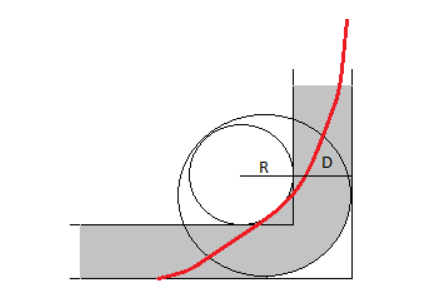
Jest to o tyle dogodne dla nas narzędzie iż dzięki takiemu przybliżeniu jesteśmy w stanie skorzystać z przekształconego wzoru i zamiast zmian kąta pod jakim pojazd się ustawia do trasy, które musiałyby bazować na dużych tablicach macierzowych za względu na pary punktów, korzystamy ze stałych promieni oraz danego przekształcenia 
\begin{equation*}
\displaystyle s=\int \sqrt((r_{1}+(r_{2}-r_{1})/s_{1}*s)/(mu*g))\operatorname{d}\!s.
\end{equation*}
Za pomocą tego wzoru zaimplementowanego do Julii sprawdzimy najkrótszą możliwą do pokonania trasę i będzie ona wartością bazową ze względu na jej stałość. 

In [3]:
##FUNKCJA PREZĘTUJĄCA ZAKRĘT
function integrand(s::Float64, r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64)
    u = r1 + (r2 - r1) / s1 * s
    sqrt(u/m*g)
end
a = 0.0
b = pi/2
max_order = 1000

1000

#### METODA PROSTOKĄTÓW

W tej metodzie korzystamy z definicji całki oznaczonej Riemanna, w której wartość całki interpretowana jest jako suma pól obszarów pod wykresem krzywej w zadanym przedziale całkowania $[x_{p}, x_{k}]$. Następnie sumę tę przybliżamy przy pomocy sumy pól odpowiednio dobranych prostokątów.

Przedział całkowania $[x_{p}, x_{k}]$ dzielimy na $n$ równo odległych punktów $x_{1}, x_{2}, ..., x_{n},$ jak na załączonej grafice.
![metoda_prostokątów.png](images\prostokaty.png)
Następnie obliczamy odległości między prostokątami
\begin{equation*}
\Delta x = \frac{x_{k}-x_{p}}{n}
\end{equation*}
Dla każdego wyznaczonego w ten sposób punktu obliczamy wartość funkcji $f(x).$
Następnie obliczamy sumę iloczynów wyznaczonych wartości funkcji przez odległość $\Delta x$ między dwoma sąsiednimi punktami
\begin{equation*}
S = f_{1}\cdot\Delta x + f_{2}\cdot\Delta x + ... + f_{n}\cdot\Delta x = \Delta x \cdot (f_{1}+f_{2}+...+f_{n})
\end{equation*}

In [4]:
function integrate_rectangles(f, a, b, n)
    delta_x = (b - a) / n
    sum = 0.0

    for i in 0:n-1
        x = a + (i + 0.5) * delta_x
        sum += f(x)
    end
    result = delta_x * sum
    result
end

P = integrate_rectangles(x -> integrand(x, 10.0, 20.0, 1.0, 1.0, 10.0), a, b, max_order)

20.81292342039796

#### METODA TRAPEZÓW

Metoda ta jest podobna do poprzedniej z tym, że zamiast prostokątów używamy trapezów o wysokościach $\Delta x$ i podstawach równych odpowiednim wartościom funkcji $f(x)$ w punktach krańcowych.
![metoda_trapezów.png](images\trapezy.png)

In [5]:
function integrate_trapezoids(r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64, a::Float64, b::Float64, n::Int64)
    delta_s = (b - a) / n
    sum = 0.0
    s = a
    for i in 1:n-1
        u = r1 + (r2 - r1) / s1 * s
        sum += integrand(s, r1, r2, s1, m, g)
        s += delta_s
    end
    result = delta_s * ((integrand(a, r1, r2, s1, m, g) + integrand(b, r1, r2, s1, m, g)) / 2.0 + sum)
    result
end
T = integrate_trapezoids(10.0, 20.0, 1.0, 1.0, 10.0, a, b, max_order)

20.803452817123272

#### METODA SIMPSONA

Metoda ta jest podobna do poprzednich z tym, że do przybliżenia stosujemy parabolę.

In [6]:
function integrate_simpson(f, a, b, n)
    delta_x = (b - a) / n
    sum = f(a) + f(b)
    for i in 1:n-1
        x = a + i * delta_x
        if iseven(i)
            sum += 2 * f(x)
        else
            sum += 4 * f(x)
        end
    end
    result = delta_x / 3 * sum
    result
end

S = integrate_simpson(x -> integrand(x, 10.0, 20.0, 1.0, 1.0, 10.0), a, b, max_order)

20.812923226956855

#### PRÓBA KONTROLNA (ZA POMOCĄ PAKIETU WBUDOWANEGO QUADGK)

In [7]:
function integrate(r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64, a::Float64, b::Float64)
    f(s) = integrand(s, r1, r2, s1, m, g)
    Q, err=quadgk(f, a, b)
    Q, err
end
W = (integrate(10.0, 20.0, 1.0, 1.0, 10.0, a, b))

(20.812923226956958, 2.063025306142663e-10)

#### ZESTAWIENIE TABELARYCZNE OBLICZEŃ DOTYCZĄCYCH DROGI ZE STAŁEGO WZORU (PORÓWNANIE METOD)

In [8]:
tabela = DataFrame(PROSTOKĄTÓW = P, TRAPEZÓW = T, SIMPSONA = S, WBUDOWANA = W[1])
tabela

1×4 DataFrame
 Row │ PROSTOKĄTÓW  TRAPEZÓW  SIMPSONA  WBUDOWANA 
     │ Float64      Float64   Float64   Float64   
─────┼────────────────────────────────────────────
   1 │     20.8129   20.8035   20.8129    20.8129

### OBLICZANIE DŁUGOŚCI WYGENEROWANYCH TRAS

#### FUNKCJA RIEMANNA

In [9]:
function riemann(f, a::Real, b::Real, n::Int; method="right")
  if method == "right"
     meth = (f,l,r) -> f(r) * (r-l)
  elseif method == "left"
     meth= (f,l,r) -> f(l) * (r-l)
  elseif method == "trapezoid"
     meth = (f,l,r) -> (1/2) * (f(l) + f(r)) * (r-l)
  elseif method == "simpsons"
     meth = (f,l,r) -> (1/6) * (f(l) + 4*(f((l+r)/2)) + f(r)) * (r-l)
  end

  xs = range(a, b, length=n+1)
  lrs = zip(Iterators.take(xs, n), Iterators.rest(xs, 1))
  sum(meth(f, l, r) for (l,r) in lrs)
end

riemann (generic function with 1 method)

#### I SPOSÓB

Pierwszy sposób jaki uwzględnimy w naszym projekcie będzie bazował na wzorze
\begin{equation*}
L = 2\pi r \left(\frac{\theta}{360^{\circ}}\right).
\end{equation*}

Zawarty jest on w pętli kodu, gdzie za pomocą ... obliczamy kąt .... Wszystkie wartości z tych obliczeń zostają dodane do tablicy dl dzięki czmu mamy zestawienie poszczególnych długości.

In [10]:
dl

1306-element Vector{Any}:
 24.637712124493355
 25.282113434237136
 24.30634733337084
 25.18498777388934
 23.97357922241995
 25.009965921659077
 24.652913325772893
 25.38429113980189
 24.437164996545132
 23.88864890349791
 25.024787317789656
 27.897795366250616
 24.10345270790827
  ⋮
 22.08439101857802
 22.808787759243774
 22.79062156497496
 25.457717606771794
 21.739037204882166
 24.136115708894813
 22.45236547527101
 21.53309648631001
 25.695538182978623
 24.200331807143606
 23.72670980941585
 22.0988470311585

#### II SPOSÓB

In [11]:
suma_kwadratow_left = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="left")
    push!(suma_kwadratow_left, dlugosc_luku)
end
# suma_kwadratow_left

suma_kwadratow_right = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="right")
    push!(suma_kwadratow_right, dlugosc_luku)
end
# suma_kwadratow_right

suma_kwadratow_trapezoid = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="trapezoid")
    push!(suma_kwadratow_trapezoid, dlugosc_luku)
end
# suma_kwadratow_trapezoid

suma_kwadratow_simpsons = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="simpsons")
    push!(suma_kwadratow_simpsons, dlugosc_luku)
end
# suma_kwadratow_simpsons

suma_kwadratow_wbudowana = []
for s in 1:length(r)
    dlugosc_luku = quadgk(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s])[1]
    push!(suma_kwadratow_wbudowana, dlugosc_luku)
end
# suma_kwadratow_wbudowana

In [12]:
suma = DataFrame(RIGHT = suma_kwadratow_right, LEFT = suma_kwadratow_left, TRAPEZÓW = suma_kwadratow_trapezoid, SIMPSONA = suma_kwadratow_simpsons, WBUDOWANA = suma_kwadratow_wbudowana)
suma

1306×5 DataFrame
  Row │ RIGHT    LEFT     TRAPEZÓW  SIMPSONA  WBUDOWANA 
      │ Any      Any      Any       Any       Any       
──────┼─────────────────────────────────────────────────
    1 │ 24.6377  24.6377  24.6377   24.6377   24.6377
    2 │ 25.2821  25.2821  25.2821   25.2821   25.2821
    3 │ 24.3063  24.3063  24.3063   24.3063   24.3063
    4 │ 25.185   25.185   25.185    25.185    25.185
    5 │ 23.9736  23.9736  23.9736   23.9736   23.9736
    6 │ 25.01    25.01    25.01     25.01     25.01
    7 │ 24.6529  24.6529  24.6529   24.6529   24.6529
    8 │ 25.3843  25.3843  25.3843   25.3843   25.3843
    9 │ 24.4372  24.4372  24.4372   24.4372   24.4372
   10 │ 23.8886  23.8886  23.8886   23.8886   23.8886
   11 │ 25.0248  25.0248  25.0248   25.0248   25.0248
  ⋮   │    ⋮        ⋮        ⋮         ⋮          ⋮
 1297 │ 22.7906  22.7906  22.7906   22.7906   22.7906
 1298 │ 25.4577  25.4577  25.4577   25.4577   25.4577
 1299 │ 21.739   21.739   21.739    21.739    21.739
 1300 │ 24.1361  24.1361  24.1361   24.1361   24.1361
 1301 │ 22.4524  22.4524  22.4524   22.4524   22.4524
 1302 │ 21.5331  21.5331  21.5331   21.5331   21.5331
 1303 │ 25.6955  25.6955  25.6955   25.6955   25.6955
 1304 │ 24.2003  24.2003  24.2003   24.2003   24.2003
 1305 │ 23.7267  23.7267  23.7267   23.7267   23.7267
 1306 │ 22.0988  22.0988  22.0988   22.0988   22.0988
                                       1285 rows omitted

#### III SPOSÓB

Kolejną metodą dzięki której będziemy mogli porównać i tym samym zweryfikować wyniki będzie program który również będzie bazował na całce oznaczonej. Natomiast tym razem będzie to wzór znany w analizie jako wzór na długość krzywej, w naszym przypadku łuku
\begin{equation*}
\displaystyle L=\int_{a}^{b} \sqrt{1+[f'(x)]^{2}}\operatorname{d}\!x.
\end{equation*}
W widocznym wzorze wykorzystując wcześniej wygenerowane losowe trasy, oraz za pomocą zaimplementowanej przez nas funkcji „wielomian”, wyznaczamy wzory wielomianów które będą reprezentować trasę. Następnie wyznaczamy pochodną odpowiedniego wielomianu, tutaj domyślnie stopnia dwa, oraz obliczymy całkę oznaczoną z pierwiastka z sumy jedynki oraz kwadratu pochodnej funkcji. Odnosząc się do samej funkcji „wielomian” bazuje ona na wartościach pdpowiadających początkowi i końcowi trasy oraz wyznaczeniu prostej przechodzącej przez te punkty. Następnie program generuje łuk oraz wyznacza $n$ punktów po których w dalszej części będzie przechodziła interacja aby z wykorzystaniem macierzy u nas w programie "A", wyznaczyć współczynniki wielomianu.

#### FUNKCJA WIELOMIAN

In [13]:
using Polynomials
function wielomian(r)
    # Wyznaczenie punktów końcowych łuku
    x1, y1 = r, 0
    x2, y2 = 0, r

    # Wyznaczenie równania prostej przechodzącej przez punkty (x1, y1) i (x2, y2)
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # Wyznaczenie punktów przecięcia okręgu i prostej
    a = m^2 + 1
    b = 2 * m * b
    c = b^2 / 4 - r^2
    delta = sqrt(b^2 - 4 * a * c)
    x_1 = (-b + delta) / (2 * a)
    #x_2 = (-b - delta) / (2 * a)
    y_1 = m * x_1 + b
    #y_2 = m * x_2 + b

    # Wyznaczenie długości łuku między punktem (x1, y1) a punktem przecięcia (x_1, y_1)
    d = sqrt((x_1 - x1)^2 + (y_1 - y1)^2)

    # Wyznaczenie liczby punktów na łuku
    n = Int(round((d / r) * pi / 2))

    # Wyznaczenie punktów na łuku
    pary_punktow_luku = [(r * cos(t), r * sin(t)) for t in range(0, stop=pi/2, length=n)]

    # Wyznaczenie stopnia wielomianu
    stopien = div(n, 2)

    # Wyznaczenie współczynników wielomianu
    xs = [point[1] for point in pary_punktow_luku]
    ys = [point[2] for point in pary_punktow_luku]
    A = ones(n, stopien+1)
    for i=1:n
        for j=2:(stopien+1)
            A[i,j] = A[i,j-1] * xs[i]
        end
    end
    punkty = (A' * A) \ (A' * ys)
    return punkty
end

wielomian (generic function with 1 method)

In [14]:
wielomiany = []
for i in r
    miara = wielomian(i)
    push!(wielomiany, Polynomial([miara[1], miara[2], miara[3]]))  # Utwórz obiekt wielomianu za pomocą Polynomial
    n = 1000  # liczba punktów
end

wyniki_right = []
wyniki_left = []
wyniki_trapezoid = []
wyniki_simpsons = []

for i in wielomiany
    f_poly = Polynomial(i)  
    f_coeffs = coeffs(f_poly)  
    f_derivative = derivative(f_poly)  
    z(x) = sqrt(1 + f_derivative(x)^2)
    rr = riemann(z, 0, 15, 1000, method="right")
    rl = riemann(z, 0, 15, 1000, method="left")
    rt = riemann(z, 0, 15, 1000, method="trapezoid")
    rs = riemann(z, 0, 15, 1000, method="simpsons")
    push!(wyniki_right, rr)
    push!(wyniki_left, rl)
    push!(wyniki_trapezoid, rt)
    push!(wyniki_simpsons, rs)
end

In [15]:
dlugosc_krzywej = DataFrame(RIGHT = wyniki_right, LEFT = wyniki_left, TRAPEZÓW = wyniki_trapezoid, SIMPSONA = wyniki_simpsons)
dlugosc_krzywej

1306×4 DataFrame
  Row │ RIGHT    LEFT     TRAPEZÓW  SIMPSONA 
      │ Any      Any      Any       Any      
──────┼──────────────────────────────────────
    1 │ 15.7718  15.7724  15.7721   15.7721
    2 │ 15.8026  15.803   15.8028   15.8028
    3 │ 15.7564  15.7571  15.7568   15.7567
    4 │ 15.7979  15.7983  15.7981   15.7981
    5 │ 15.7414  15.7422  15.7418   15.7418
    6 │ 15.7894  15.7899  15.7897   15.7897
    7 │ 15.7725  15.7731  15.7728   15.7728
    8 │ 15.8075  15.8079  15.8077   15.8077
    9 │ 15.7624  15.7631  15.7627   15.7627
   10 │ 15.7377  15.7385  15.7381   15.7381
   11 │ 15.7902  15.7906  15.7904   15.7904
  ⋮   │    ⋮        ⋮        ⋮         ⋮
 1297 │ 16.4407  16.4381  16.4394   16.4394
 1298 │ 16.7693  16.7654  16.7673   16.7673
 1299 │ 16.279   16.277   16.278    16.278
 1300 │ 16.6219  16.6186  16.6202   16.6202
 1301 │ 16.3905  16.388   16.3892   16.3892
 1302 │ 16.2456  16.2438  16.2447   16.2447
 1303 │ 16.7926  16.7886  16.7906   16.7906
 1304 │ 16.6298  16.6264  16.6281   16.6281
 1305 │ 16.5701  16.5669  16.5685   16.5685
 1306 │ 16.3361  16.3339  16.335    16.335
                            1285 rows omitted

#### TABELARYCZNE PORÓWNANIE WSZYSTKICH METOD (PRZY ZMIENNYCH DANYCH)

Wyniki w kolumnach "RIGHT", "LEFT", "TRAPEZÓW" i "SIMPSONA" są obliczane za pomocą metod numerycznych (np. metoda prawych końców, lewych końców, trapezów i Simpsona), które są przybliżone. Z drugiej strony, wyniki w kolumnach "WYCINEK" i "SUMA_KWADRATÓW_WBUDOWANA" są obliczane za pomocą metody geometrycznej, która jest dokładniejsza, ponieważ opiera się na bezpośrednim wyznaczeniu długości łuku i sumy kwadratów.

Metody numeryczne, takie jak metoda Riemanna, stosują przybliżone wartości funkcji na przedziałach, a wynik całkowania jest sumą tych przybliżonych wartości. 

Z drugiej strony, metoda geometryczna opiera się na bezpośrednim wyznaczeniu długości łuku lub sumy kwadratów na podstawie geometrii figury. Jest to dokładniejsza metoda, ponieważ uwzględnia bezpośrednio kształt krzywej.

W rezultacie wyniki w kolumnach "WYCINEK" i "SUMA_KWADRATÓW_WBUDOWANA" mogą różnić się od wyników w kolumnach "RIGHT", "LEFT", "TRAPEZÓW" i "SIMPSONA". Różnica ta wynika z charakteru różnych metod obliczania całki i przybliżania wartości funkcji.

In [24]:
dlugosc_drogi = DataFrame(RIGHT = wyniki_right, LEFT = wyniki_left, TRAPEZÓW = wyniki_trapezoid, SIMPSONA = wyniki_simpsons, WYCINEK = dl, SUMA_KWADRATÓW_WBUDOWANA = suma_kwadratow_wbudowana)
dlugosc_drogi

1306×6 DataFrame
  Row │ RIGHT    LEFT     TRAPEZÓW  SIMPSONA  WYCINEK  SUMA_KWADRATÓW_WBUDOWAN ⋯
      │ Any      Any      Any       Any       Any      Any                     ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 15.7718  15.7724  15.7721   15.7721   24.6377  24.6377                 ⋯
    2 │ 15.8026  15.803   15.8028   15.8028   25.2821  25.2821
    3 │ 15.7564  15.7571  15.7568   15.7567   24.3063  24.3063
    4 │ 15.7979  15.7983  15.7981   15.7981   25.185   25.185
    5 │ 15.7414  15.7422  15.7418   15.7418   23.9736  23.9736                 ⋯
    6 │ 15.7894  15.7899  15.7897   15.7897   25.01    25.01
    7 │ 15.7725  15.7731  15.7728   15.7728   24.6529  24.6529
    8 │ 15.8075  15.8079  15.8077   15.8077   25.3843  25.3843
    9 │ 15.7624  15.7631  15.7627   15.7627   24.4372  24.4372                 ⋯
   10 │ 15.7377  15.7385  15.7381   15.7381   23.8886  23.8886
   11 │ 15.7902  15.7906  15.7904   15.7904   25.0248  25.0248
  ⋮   │    ⋮        ⋮        ⋮         ⋮         ⋮                ⋮            ⋱
 1297 │ 16.4407  16.4381  16.4394   16.4394   22.7906  22.7906
 1298 │ 16.7693  16.7654  16.7673   16.7673   25.4577  25.4577                 ⋯
 1299 │ 16.279   16.277   16.278    16.278    21.739   21.739
 1300 │ 16.6219  16.6186  16.6202   16.6202   24.1361  24.1361
 1301 │ 16.3905  16.388   16.3892   16.3892   22.4524  22.4524
 1302 │ 16.2456  16.2438  16.2447   16.2447   21.5331  21.5331                 ⋯
 1303 │ 16.7926  16.7886  16.7906   16.7906   25.6955  25.6955
 1304 │ 16.6298  16.6264  16.6281   16.6281   24.2003  24.2003
 1305 │ 16.5701  16.5669  16.5685   16.5685   23.7267  23.7267
 1306 │ 16.3361  16.3339  16.335    16.335    22.0988  22.0988                 ⋯
                                                  1 column and 1285 rows omitted

## NAJKRÓTSZA TRASA NA WYKRESIE

In [19]:
plot(tab3, tab4, -pi, pi, aspectratio=1, linewidth=1, xlim=(0, ograniczenie_g),
     ylim=(0, ograniczenie_g), legend=false)
plot!(tab1, tab2, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)
plot!(tab3[argmin(dl)], tab4[argmin(dl)], -pi, pi, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)

## ANIMACJA TRASY

[ Info: Saved animation to C:\Users\Aleksandra\OneDrive\Documents\PROGRAMOWANIE\Julia\Projekt_Pakiety_Matematyczne\tmp.gif


Plots.AnimatedGif("C:\\Users\\Aleksandra\\OneDrive\\Documents\\PROGRAMOWANIE\\Julia\\Projekt_Pakiety_Matematyczne\\tmp.gif")
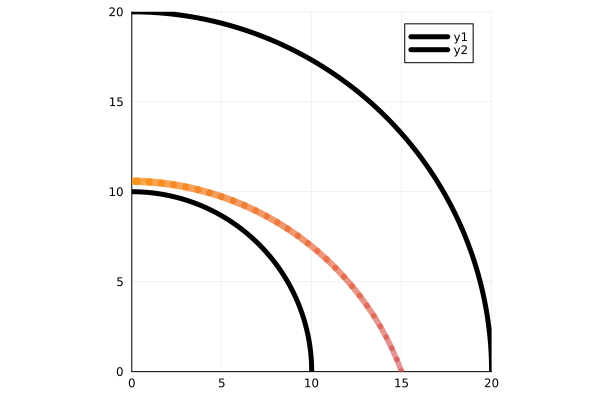

In [ ]:
@userplot CirclePlot
@recipe function f(cp::CirclePlot)
    x, y, i = cp.args
    n = length(x)
    inds = circshift(1:n, 1 - i)
    linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    x[inds], y[inds]
end

function animacja(num)
    n = 150
    t = range(-pi, π, length = n)
    y6 = r[num]*sin.(t) .+ y[num]
    x6 = r[num]*cos.(t) .+ x3[num] 
    
    anim = @animate for i ∈ 1:n
        circleplot!(x6, y6, i)
    end
    
    @gif for i ∈ 1:n
        plot(tab1, tab2, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)
        circleplot!(x6, y6, i, line_z = 1:n, cbar = false, framestyle = :zerolines,  xlim=(0,20), ylim=(0, 20))
    end every 5
end

animacja(argmin(dl))